## author: Virginia Ordoño Bernier
## date: december 2023


## Prácticas Naive Bayes y KNN (ejercicio 1)

#### **1. Tomando como base este [tutorial](https://colab.research.google.com/drive/1zFIOfrceEaFkhQOEOkMWroBmNV1HAMVS?usp=drive_link),  crea un modelo de clasificación usando KNN con los mismos datos sintéticos. Para la elección de los mejores hiperparámetros usa un sistema de [validación cruzada](https://educacionadistancia.juntadeandalucia.es/centros/cordoba/pluginfile.php/406946/mod_resource/content/1/M2_SAA_S10%20-%20Validaci%C3%B3n.pdf).**

#### 2. Usando los datos almacenados en data2.csv, crea un modelo de clasificación usando los modelos de NaiveBayes mostrados en el [vídeo 5](https://vimeo.com/600140324). Indicad qué modelo da mejores resultados. Os toca investigar cómo cargar un archivo csv desde Google Collab.

#### 3. En este [enlace](https://www.kaggle.com/datasets/uciml/red-wine-quality-cortez-et-al-2009) puedes descargar un dataset que recoge diferentes características de vino rojo portugués "Vinho Verde" y la calidad del mismo. Crea un modelo de clasificación usando NaiveBayes (GaussianNB) y KNN.

#### 4. Plantea el problema anterior con un modelo de regresión usando KNN. En el [vídeo 7](https://vimeo.com/600141357) hay un ejemplo de regresión con KNN.

In [19]:
import numpy as np

#### 1. Generación de datos sintéticos


In [20]:
np.random.seed(41)

# Clase 0. Distribución normal de media 0 y desviación estándar 1
class_0_data = np.random.normal(0, 1, size=(100, 2))
class_0_labels = np.zeros(100) # Representación de etiquetas como ceros

# Clase 1. Distribución normal de media 3 y desviación estándar 1
class_1_data = np.random.normal(3, 1, size=(100, 2))
class_1_labels = np.ones(100) # Representación de etiquetas como unos

#### 2. Carga de datos

In [28]:
# Formateo de datos
X = np.vstack((class_0_data, class_1_data)) # Une dos matrices en una en forma de pila
y = np.concatenate((class_0_labels, class_1_labels)) # Concatena las matrices de los nombres en una en forma de columna

# Carga en Dataframe
import pandas as pd

# Crear DataFrames para las características y etiquetas
df_X = pd.DataFrame(X, columns=['Class_0', 'Class_1']) 
df_y = pd.DataFrame(y, columns=['Label'])

# Concatenar DataFrames
df_classes = pd.concat([df_X, df_y], axis=1)

# Clase label solo con enteros
df_classes.Label = df_classes.Label.astype(int)

df_classes


,Class_0,Class_1,Label
0,-0.270712,0.104848,0
1,0.250528,-0.925200,0
2,0.567144,-1.040180,0
3,-0.153676,0.789852,0
4,-1.226216,-0.948007,0
...,...,...,...
195,3.754550,4.091037,1
196,3.957150,3.399005,1
197,1.118678,2.318888,1
198,4.010052,3.822308,1


#### 2. Visualización de datos


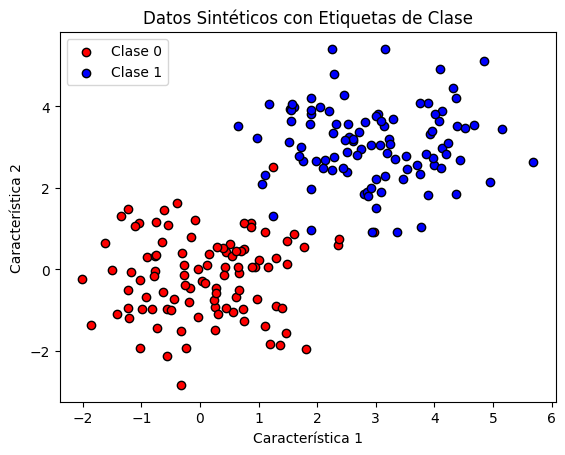

In [21]:
import matplotlib.pyplot as plt

colors = ('red', 'blue')

for i, data in enumerate((class_0_data, class_1_data)):
    plt.scatter(data[:, 0], data[:, 1], c=colors[i], edgecolor='k', label=f"Clase {i}")

plt.title('Datos Sintéticos con Etiquetas de Clase')
plt.xlabel('Característica 1')
plt.ylabel('Característica 2')
plt.legend()

plt.show()

#### 3. Creación de conjuntos de entrenamiento y prueba


In [22]:
import pandas as pd
from sklearn.model_selection import train_test_split

X = np.vstack((class_0_data, class_1_data))
y = np.concatenate((class_0_labels, class_1_labels))

# Dividir el conjunto de datos en entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### 4. Creación del modelo KNN


In [23]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

# Crear y entrenar el modelo KNN
knn_model = KNeighborsClassifier(n_neighbors=3)
knn_model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = knn_model.predict(X_test)

# Evaluar la precisión del modelo
accuracy = accuracy_score(y_test, y_pred)
print(f'Precisión del modelo KNN: {accuracy}')

# Mostrar el informe de clasificación
print("\nInforme de clasificación:")
print(classification_report(y_test, y_pred, target_names=['Clase 0', 'Clase 1']))


Precisión del modelo KNN: 0.95

Informe de clasificación:
              precision    recall  f1-score   support

     Clase 0       0.91      1.00      0.95        21
     Clase 1       1.00      0.89      0.94        19

    accuracy                           0.95        40
   macro avg       0.96      0.95      0.95        40
weighted avg       0.95      0.95      0.95        40



#### 5. Matriz de confusión


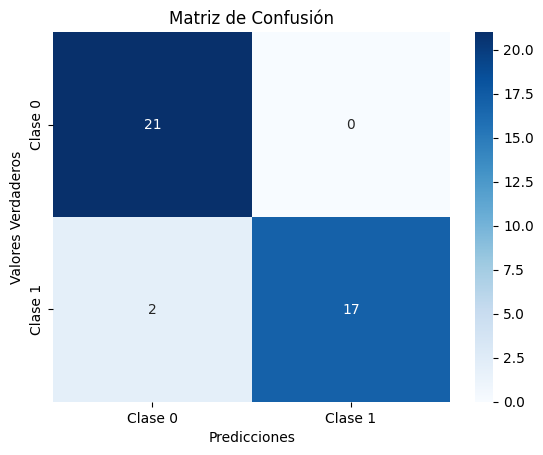

In [24]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)

classes = ('Clase 0', 'Clase 1')
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Matriz de Confusión')
plt.xlabel('Predicciones')
plt.ylabel('Valores Verdaderos')
plt.show()

### 6. Valildación cruzada

In [26]:
from sklearn.model_selection import train_test_split

# Dividimos el conjunto de datos en train y test en un porcentaje de 2/3 vs 1/3

train, test = train_test_split(data[['clase 0','clase 1', 'target']], test_size=0.33)
train.reset_index(inplace = True)
test.reset_index(inplace = True)


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [ ]:
from sklearn.model_selection import KFold


cv = KFold(n_splits = 5, shuffle = True) # shuffle = False si hay dimensión temporal


for i, weights in enumerate(['uniform', 'distance']):
   total_scores = []
   
   for n_neighbors in range(1,30):
      fold_accuracy = []
      knn = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights)

      for train_fold, test_fold in cv.split(train):
         # División train test aleatoria
         f_train = train.loc[train_fold]
         f_test = train.loc[test_fold]
         # entrenamiento y ejecución del modelo
         knn.fit( X = f_train.drop(['target'], axis=1),
                              y = f_train['target'])
         y_pred = knn.predict(X = f_test.drop(['target'], axis = 1))
         # evaluación del modelo
         acc = accuracy_score(f_test['target'], y_pred)
         fold_accuracy.append(acc)
      total_scores.append(sum(fold_accuracy)/len(fold_accuracy))

   plt.plot(range(1,len(total_scores)+1), total_scores,
             marker='o', label=weights)
   print ('Max Value ' +  weights + " : " +  str(max(total_scores)) +" (" + str(np.argmax(total_scores) + 1) + ")")
   plt.ylabel('Acc')


plt.legend()
plt.show()